# COVID 19 classification


Version 3, November 2020, working on fastai v2.

In [1]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import fastai; fastai.__version__

'2.1.8'

In [4]:
torch.cuda.is_available()

True

In [15]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [6]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [7]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from dataset (including covids!) 

In [8]:
dfTrain = pd.read_csv(path+'train_split_v3.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train/processed/' + dfTrain[0].astype(str)
dfTrain.head()

idx_pa = dfTrain[1] == "COVID-19"  # Get COVID to augment.
dfTrain_covid =  dfTrain[idx_pa]
print(len (dfTrain_covid))
#augment de training covid data 2^3
for i in range(3):
    dfTrain_covid = dfTrain_covid.append(dfTrain_covid)
print('Org train '+str(len (dfTrain)))
dfTrain = dfTrain.append(dfTrain_covid)
print('Augmented train '+str(len (dfTrain)))


# adding padchest
dfTrain_padchest = pd.read_csv(path+'padchest/train_split_np.csv', header=None)
dfTrain_padchest['valid'] = 0
dfTrain_padchest[0] = 'padchest/trainNP/processed/' + dfTrain_padchest[0].astype(str)
dfTrain = dfTrain.append(dfTrain_padchest)

print('Final train '+str(len (dfTrain)))

271
Org train 13687
Augmented train 15855
Final train 24290


### not done in v3 Load COVID for training from covid_vicorob

In [9]:
#dfTrainCovid = pd.read_csv(path+'covid_vicorob/covid_vicorob.csv', header=None)
#dfTrainCovid['valid'] = 0
#dfTrainCovid[0] = 'covid_vicorob/' + dfTrainCovid[0].astype(str)
#dfTrainCovid.head()
#print(len (dfTrainCovid))
#augment de training covid data 2^3
#for i in range(2):
#    dfTrainCovid = dfTrainCovid.append(dfTrainCovid)
#dfTrain = dfTrain.append(dfTrainCovid)
#print(len (dfTrain))


### Validation data from Seram & Normals

In [10]:
dfTest = pd.read_csv(path+'test_split_v3.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test/processed/' + dfTest[0].astype(str)
dfTest.head()

,0,1,valid
0,test/processed/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg,pneumonia,1
1,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg,pneumonia,1
2,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg,pneumonia,1
3,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg,pneumonia,1
4,test/processed/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg,pneumonia,1


In [11]:
# dfTestCovid = pd.read_csv(path+'seram/covid_seram.csv',header=None)
# dfTestCovid['valid'] = 1
# dfTestCovid[0] = 'seram/' + dfTestCovid[0].astype(str)
# dfTestCovid.head()
# dfTest= dfTest.append(dfTestCovid)

In [12]:
df = dfTrain.append(dfTest)
df.head()

,0,1,valid
0,train/processed/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg,pneumonia,0
1,train/processed/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg,pneumonia,0
2,train/processed/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg,pneumonia,0
3,train/processed/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg,pneumonia,0
4,train/processed/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg,pneumonia,0


In [48]:
np.random.seed(42)

tfms = [*aug_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
     max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]

#tfms = []
dls = ImageDataLoaders.from_df(df=df,path=path,  convert_mode='L', valid_col='valid', batch_tfms =tfms,
                              bs = bs, item_tfms = Resize(size = size_1, method ='squish'))

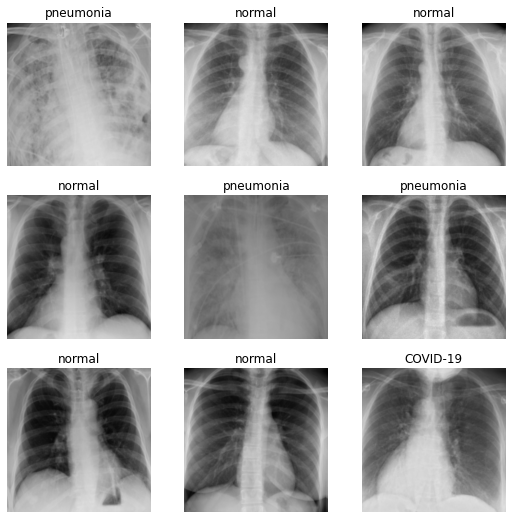

In [46]:
dls.show_batch()

In [21]:
len(dls.train_ds)

24290

In [22]:
len(dls.valid_ds)


1579

In [49]:
dls.valid_ds


(#1579) [(PILImage mode=RGB size=1604x1275, TensorCategory(2)),(PILImage mode=RGB size=1274x1068, TensorCategory(2)),(PILImage mode=RGB size=1164x1121, TensorCategory(2)),(PILImage mode=RGB size=1184x1075, TensorCategory(2)),(PILImage mode=RGB size=1202x1030, TensorCategory(2)),(PILImage mode=RGB size=866x716, TensorCategory(0)),(PILImage mode=RGB size=872x758, TensorCategory(0)),(PILImage mode=RGB size=873x726, TensorCategory(0)),(PILImage mode=RGB size=906x723, TensorCategory(0)),(PILImage mode=RGB size=2504x2205, TensorCategory(0))...]

### Convert to grayscale

In [24]:
print((dls.valid_ds[0]))


(PILImage mode=RGB size=1604x1275, TensorCategory(2))


In [34]:
# ## todo v2 not working
# for itemList in ["train_ds", "valid_ds", "fix_ds", "test_ds"]:
#     itemList = getattr(dls, itemList)
#     if itemList:
#         for x in itemList:
#             x[0].convert_mode = "L"
            


In [35]:
dls.valid_ds

(#1579) [(PILImage mode=RGB size=1604x1275, TensorCategory(2)),(PILImage mode=RGB size=1274x1068, TensorCategory(2)),(PILImage mode=RGB size=1164x1121, TensorCategory(2)),(PILImage mode=RGB size=1184x1075, TensorCategory(2)),(PILImage mode=RGB size=1202x1030, TensorCategory(2)),(PILImage mode=RGB size=866x716, TensorCategory(0)),(PILImage mode=RGB size=872x758, TensorCategory(0)),(PILImage mode=RGB size=873x726, TensorCategory(0)),(PILImage mode=RGB size=906x723, TensorCategory(0)),(PILImage mode=RGB size=2504x2205, TensorCategory(0))...]

## learner

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.fine_tune??

In [ ]:
learn.fit_one_cycle??

In [66]:

model = xresnet50()
# learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate])
learn = Learner(dls, model, metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate])


In [68]:
lr = 1e-05
# learn.fine_tune(5,base_lr=lr)
slice (lr)
#learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
learn.fine_tune(10, base_lr=3e-4, freeze_epochs=3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.620711,0.465434,0.820773,0.806575,0.820773,0.179227,03:31
1,0.568671,0.418471,0.846105,0.840330,0.846105,0.153895,03:18
2,0.489516,0.385781,0.860038,0.855573,0.860038,0.139962,03:25


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.406929,0.328791,0.872704,0.870733,0.872704,0.127296,03:26
1,0.415858,0.376160,0.864471,0.883794,0.864471,0.135529,03:26
2,0.366076,0.357627,0.862571,0.889041,0.862571,0.137429,03:25
3,0.336812,0.278754,0.893604,0.894608,0.893604,0.106396,03:23
4,0.324053,0.282047,0.897403,0.899488,0.897403,0.102597,03:32
5,0.292333,0.260787,0.909436,0.909802,0.909436,0.090564,03:26
6,0.241867,0.246535,0.918303,0.916521,0.918303,0.081697,03:22
7,0.209204,0.266266,0.922103,0.922402,0.922103,0.077897,03:28
8,0.194224,0.253237,0.920203,0.920067,0.920203,0.079797,03:22
9,0.178125,0.249080,0.920203,0.919970,0.920203,0.079797,03:25


RuntimeError: cannot perform reduction function argmin on a tensor with no elements because the operation does not have an identity

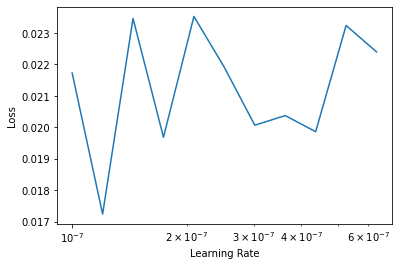

In [51]:
lr_min,lr_steep = learn.lr_find()
print(lr_min, lr_steep)

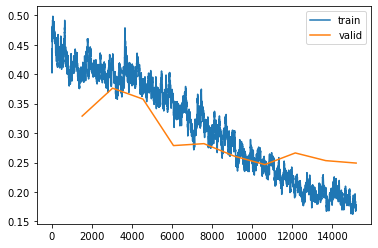

In [69]:
learn.recorder.plot_loss()

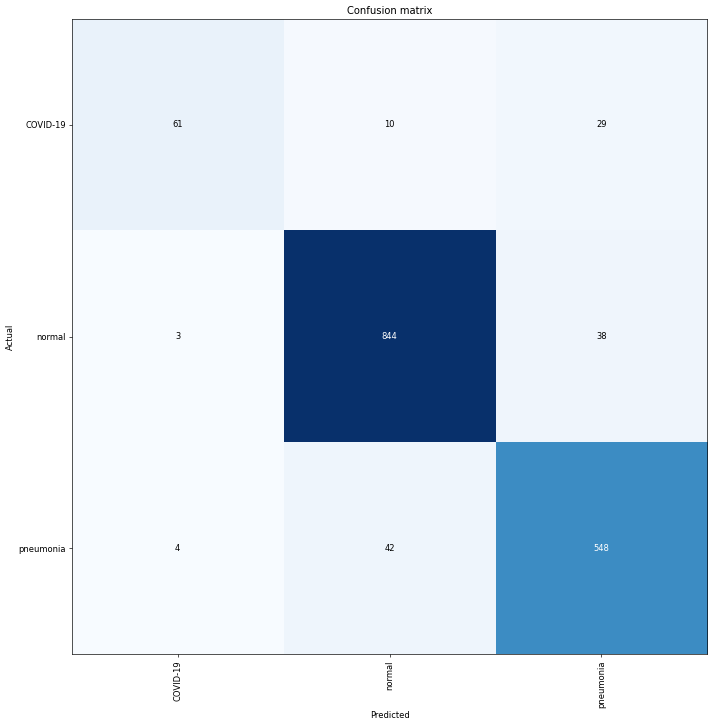

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [71]:
learn.save('stage-1_2-'+str(size_1)+'-dn50v2')

Path('/home/robert/data/covid/models/stage-1_2-256-dn50v2.pth')

In [72]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 42),
 ('normal', 'pneumonia', 38),
 ('COVID-19', 'pneumonia', 29),
 ('COVID-19', 'normal', 10),
 ('pneumonia', 'COVID-19', 4),
 ('normal', 'COVID-19', 3)]

In [78]:
cm = interp.confusion_matrix()


In [84]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.61       0.95367232 0.92255892]


In [86]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.89705882 0.94196429 0.89105691]


### increasing image size

In [40]:
data = (src.transform(tfms, size=size_2)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.batch_size = bs
data.train_ds[0][0].shape

torch.Size([1, 512, 512])

In [41]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


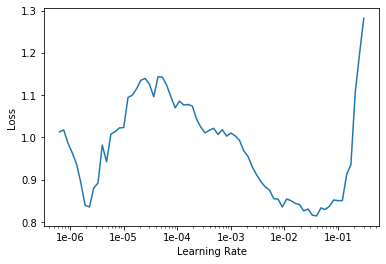

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
lr=1e-3/2

In [44]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.418643,0.303741,0.909436,0.915097,0.090564,05:42
1,0.249838,0.188957,0.937302,0.942620,0.062698,05:40
2,0.206381,0.162187,0.941735,0.951303,0.058265,05:40
3,0.176158,0.150188,0.941102,0.950193,0.058898,05:41
4,0.190179,0.151522,0.949968,0.958137,0.050032,05:41
5,0.149862,0.142504,0.950602,0.962395,0.049398,05:41
6,0.148409,0.151642,0.952502,0.959643,0.047498,05:41
7,0.141656,0.147072,0.946802,0.958123,0.053198,05:41
8,0.148497,0.141837,0.951235,0.962382,0.048765,05:41
9,0.149511,0.146254,0.949335,0.960855,0.050665,05:41


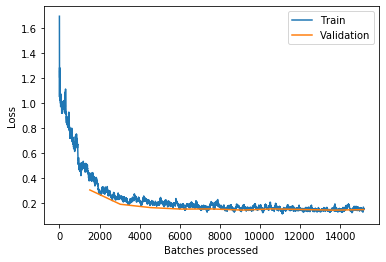

In [45]:
learn.recorder.plot_losses()

In [46]:
learn.save('stage-1-'+str(size_2)+'-rn50')

In [47]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


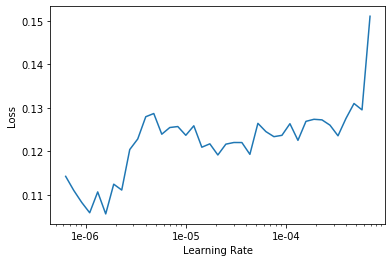

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(30, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.141127,0.145047,0.949968,0.961607,0.050032,07:59
1,0.142780,0.148377,0.951235,0.958705,0.048765,07:57
2,0.137950,0.143558,0.946168,0.957267,0.053832,07:57
3,0.152034,0.151262,0.943635,0.958570,0.056365,07:59
4,0.128115,0.156098,0.946802,0.962752,0.053198,08:00
5,0.162925,0.138119,0.951235,0.962119,0.048765,07:58
6,0.097967,0.152410,0.947435,0.959959,0.052565,07:59
7,0.115620,0.157058,0.949968,0.963152,0.050032,07:58
8,0.109314,0.167514,0.947435,0.962645,0.052565,07:59
9,0.098479,0.169341,0.945535,0.954518,0.054465,07:57


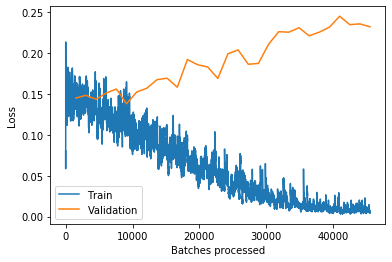

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save('stage-2-'+str(size_2)+'-rn50')


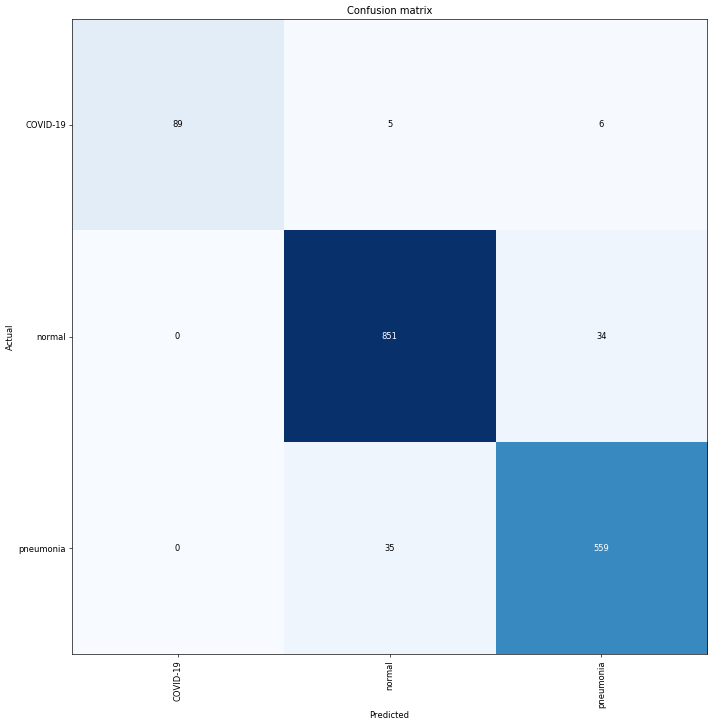

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

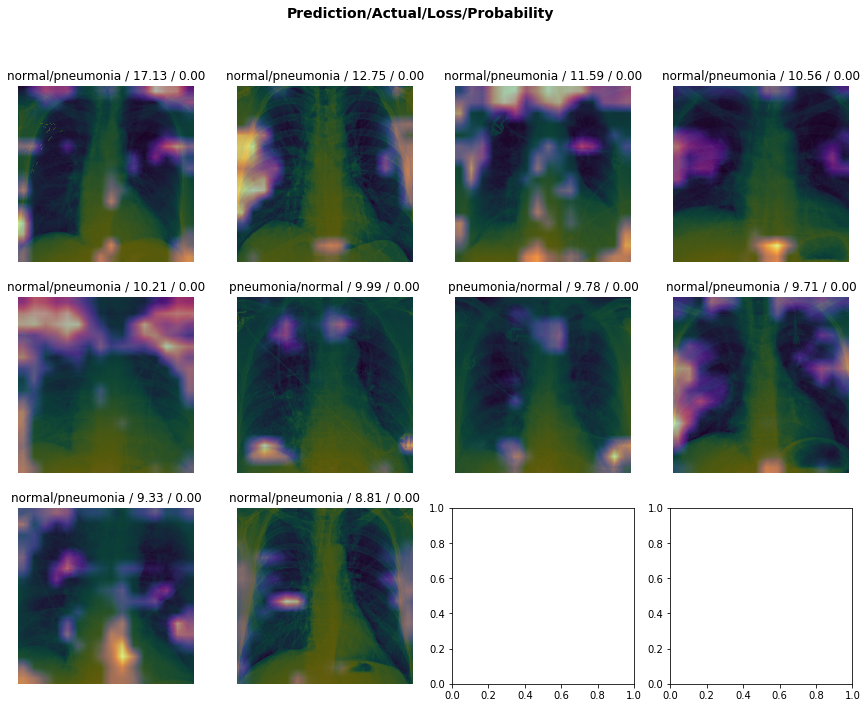

In [53]:
interp.plot_top_losses(10, figsize=(15,11), largest=True, heatmap= True)

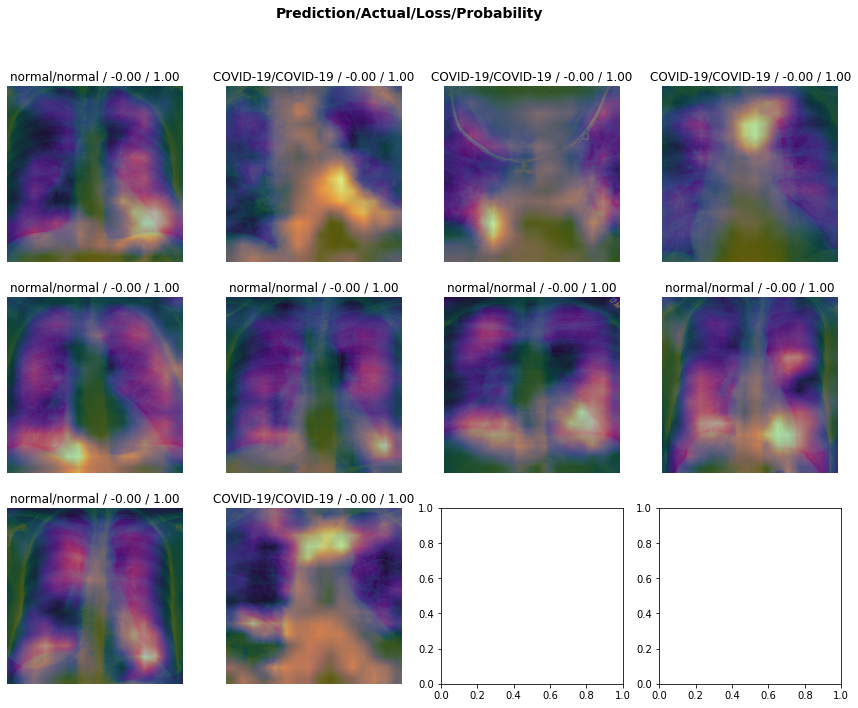

In [54]:
interp.plot_top_losses(10, figsize=(15,11), largest=False, heatmap= True)

In [55]:
learn.export('trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')

### Test on new data

In [56]:
learn = load_learner(path,'trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')


#preds,y = learn.get_preds()



In [57]:
# Data from trueta, Tic Salut, Udiat
dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
dfTest2.head()
dfTest = dfTest.append(dfTest2)

# padchest to include normals and pneumonia (not used for training/validation/testing)
dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
dfTest3.head()
dfTest = dfTest.append(dfTest3)

#salutms (120 cases)
dfTest4 = pd.read_csv(path+'salutms/salutms.csv',header=None)
dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)
dfTest4.head()
dfTest = dfTest.append(dfTest4)


In [58]:
src = (ImageList.from_df(df=dfTest,path=path,convert_mode='L')
    .split_none()
    .label_from_df())

test = (src.transform(tfms, size=512)
        .databunch(no_check=False,bs=1).normalize(imagenet_stats))
test.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fc8a01e0ef0>, device=device(type='cuda', index=0), tfms=[functools.partial(<function _normalize_batch at 0x7fc91a8d57b8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7fc922d0c488>)

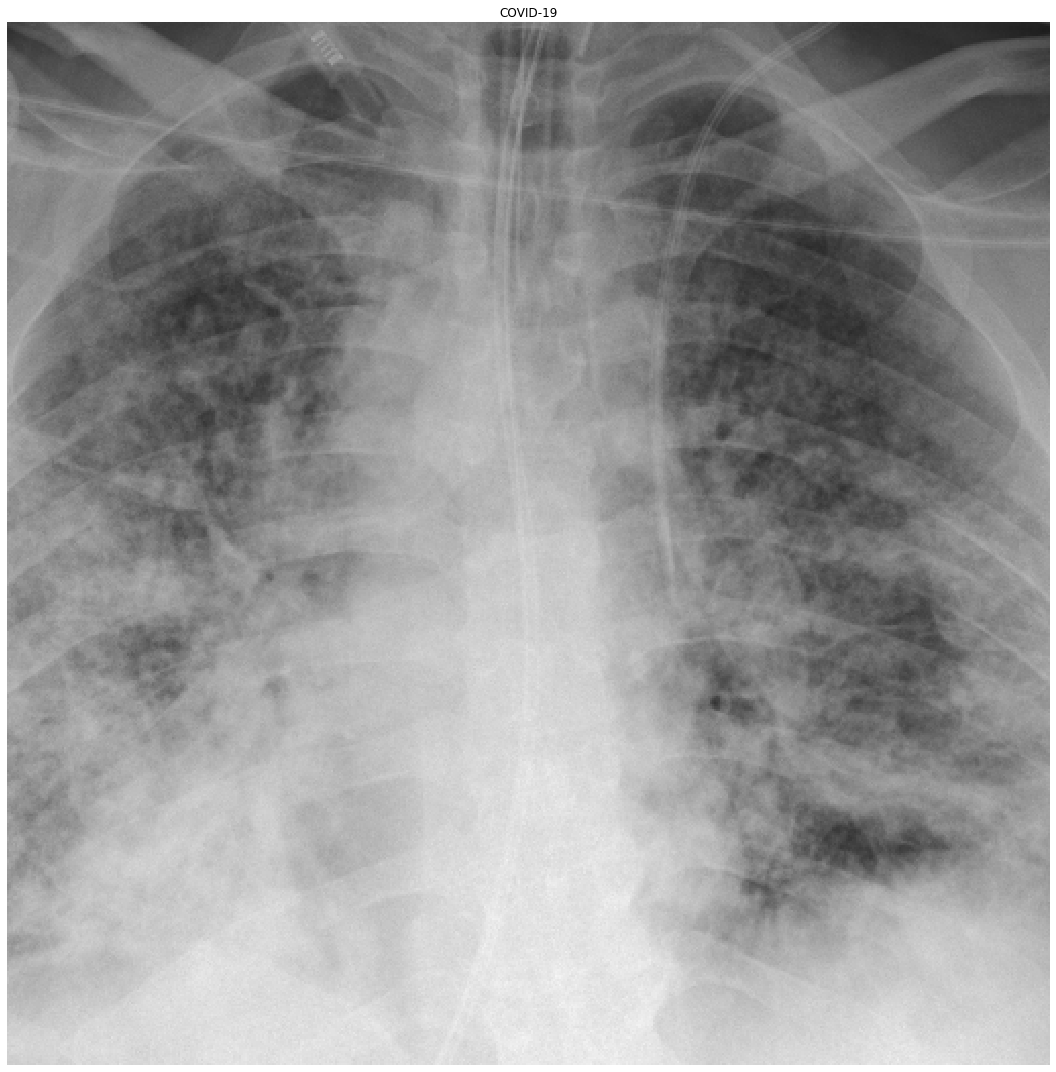

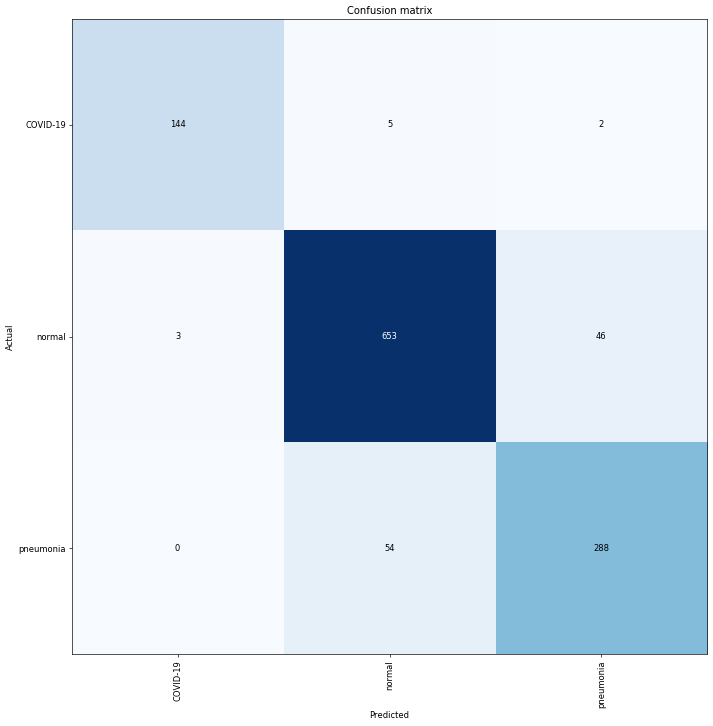

In [59]:
test.valid_dl = test.train_dl

test.show_batch(rows=13,figsize=(15,15))

for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(test, itemList)
    if itemList: itemList.x.convert_mode = "L"


learn.data.valid_dl = test.train_dl
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [60]:
log_preds, y = learn.get_preds()

predIdxs = np.argmax(log_preds.numpy(), axis=1)
print(exp(log_preds))



tensor([[1.0000, 1.0004, 2.7172],
        [2.7145, 1.0013, 1.0001],
        [1.0000, 1.0000, 2.7183],
        ...,
        [1.0000, 2.7183, 1.0000],
        [1.0000, 2.7176, 1.0003],
        [2.6264, 1.0000, 1.0350]])


In [61]:
len(data.valid_ds)
predIdxs
log_preds
predIdxs

array([2, 0, 2, 1, ..., 1, 1, 1, 0])

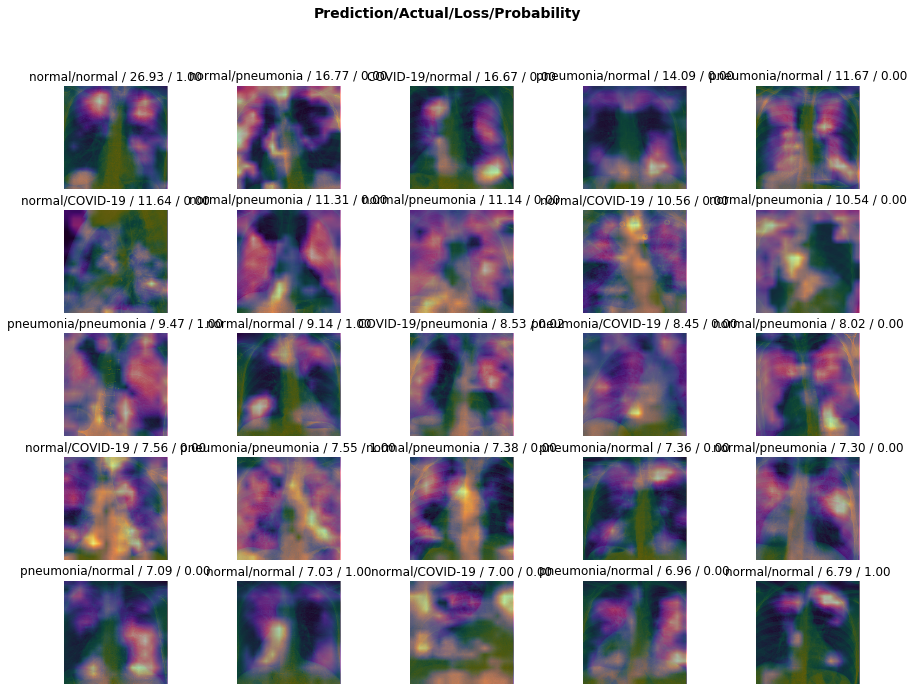

In [62]:
interp.plot_top_losses(25, figsize=(15,11), largest=True, heatmap= True)

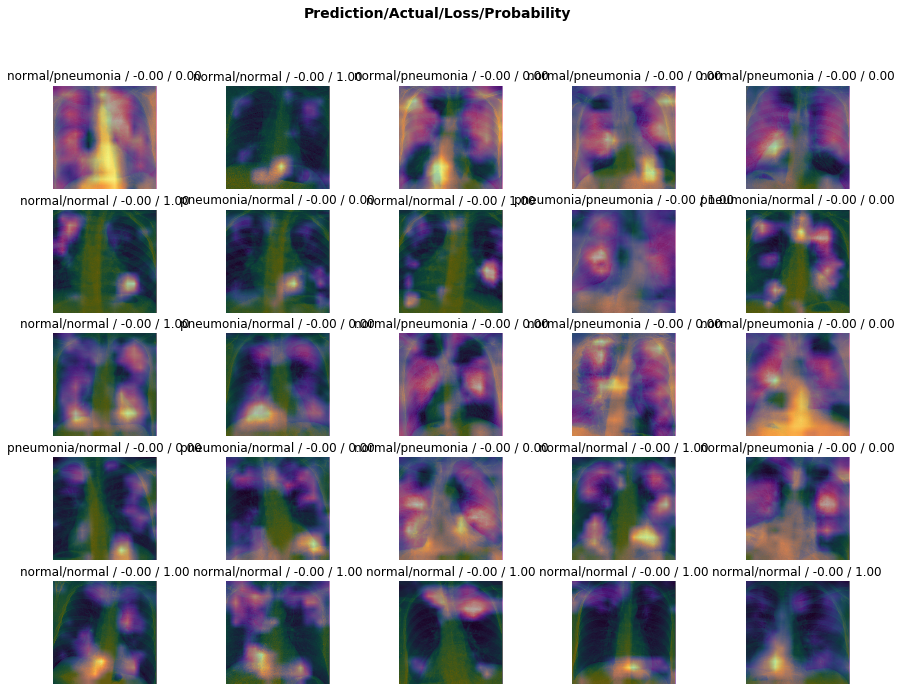

In [63]:
interp.plot_top_losses(25, figsize=(15,11), largest=False, heatmap= True)